In [145]:

import numpy as np
import matplotlib.pyplot as plt
import fixedpoint

import os
from scipy.io import wavfile
from IPython.display import Audio

PLOT = True

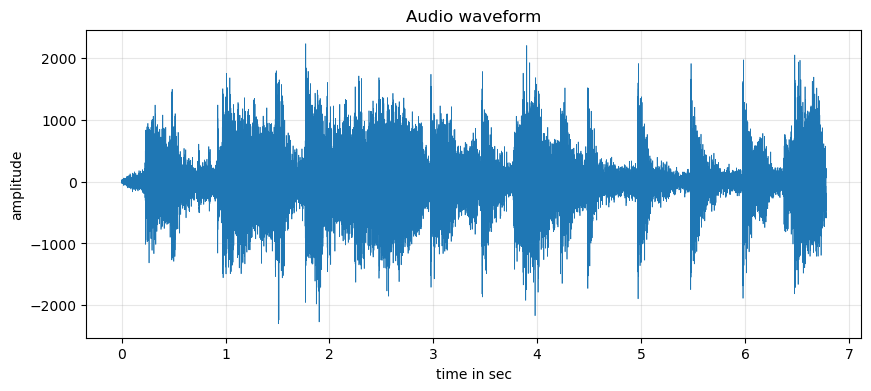

In [147]:
#input audio sample for DSP

tracks_location = "C:/Users/penel/MTRX_3700/Assignment 2"
expected_bpm = 120

input_audio_file = os.path.join(tracks_location, f"{expected_bpm}bpm_music.wav")
Audio(input_audio_file)

fs, signal = wavfile.read(input_audio_file)
signal = signal.astype(np.int64)
signal_length = len(signal) #number of samples in the signal

t = np.linspace(0, signal_length/fs, signal_length)

plt.figure(figsize=(10,4))
plt.plot(t, signal, linewidth=0.5)
plt.xlabel("time in sec")
plt.ylabel("amplitude")
plt.title("Audio waveform")
plt.grid(True, alpha=0.3)
plt.show()

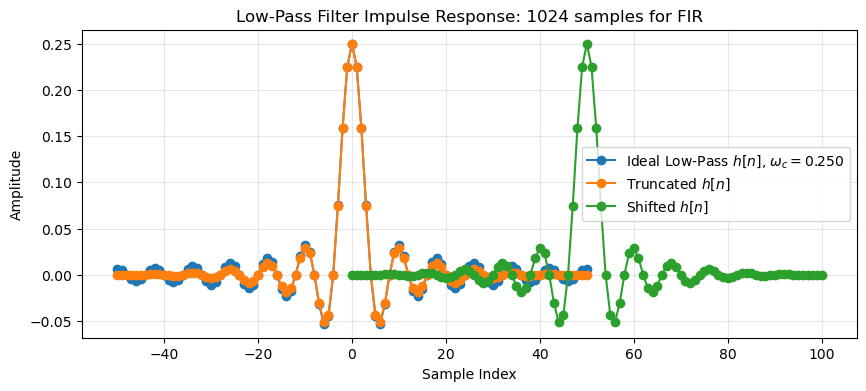

In [204]:
#Decimation and Low Pass Filter

#impulse Response that will be applied to audio sample
N = 101; #frame size of 1024 samples
cutoff_freq = fs / 8

omega_c = 2 * cutoff_freq / fs #normalised - Nyquist = fs/2
n = np.arange(N) - (N-1)/2
impulse_response = omega_c * np.sinc(omega_c * n)

plt.figure(figsize=(10,4))
plt.plot(n, impulse_response, "-o")

#truncate impulse with hanning window + shift to be n >= 0
impulse_response = impulse_response * np.hanning(N)
plt.plot(n, impulse_response, "o-")

n = np.arange(0, N)

#plot
plt.plot(n, impulse_response, "-o")
plt.title("Low-Pass Filter Impulse Response: 1024 samples for FIR")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend([f"Ideal Low-Pass $h[n]$, $\\omega_c={omega_c:.3f}$", "Truncated $h[n]$", "Shifted $h[n]$"])
plt.grid(True, alpha=0.3)


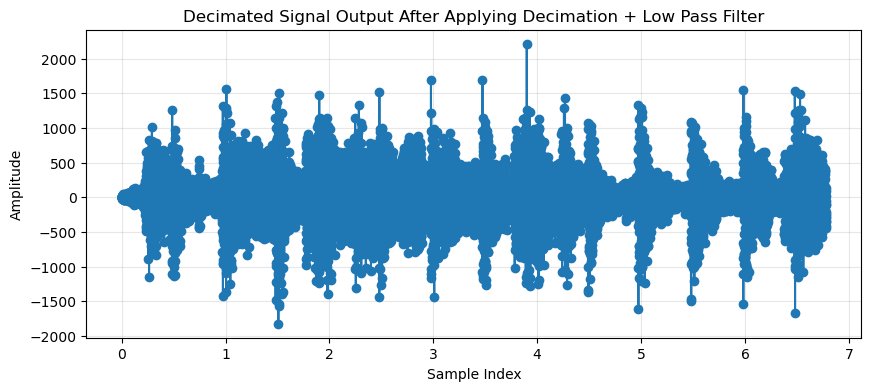

In [206]:
#apply low pass filter
filtered_signal = np.convolve(signal, impulse_response, mode="same")

#decimate
decimation_factor = 4
fs_decimated = fs / decimation_factor #new sampling frequency
decimated_signal = filtered_signal[::decimation_factor]

#plotting
t_decimated = np.linspace(0, len(decimated_signal)/fs_decimated, len(decimated_signal))

plt.figure(figsize=(10,4))
plt.plot(t_decimated, decimated_signal, "-o")
plt.title("Decimated Signal Output After Applying Decimation + Low Pass Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True, alpha = 0.3)

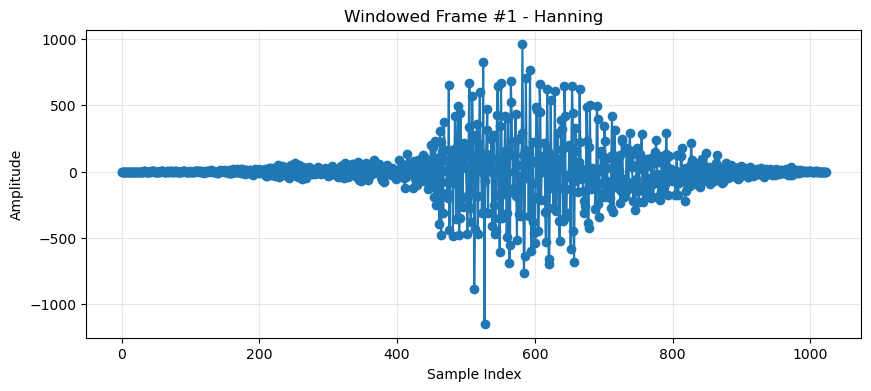

In [208]:
#FIFO modelling - split audio signal into windows of 1024
fifo_size = 1024
num_frames = (len(decimated_signal)) - fifo_size

fifo_frames = np.array([decimated_signal[i:i+fifo_size] for i in range (num_frames)])

# Hanning Window
window = np.hanning(fifo_size)
windowed_frames = np.array([frame * window for frame in fifo_frames])

plt.figure(figsize=(10,4))
plt.plot(windowed_frames[1], "-o")
plt.title("Windowed Frame #1 - Hanning")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)


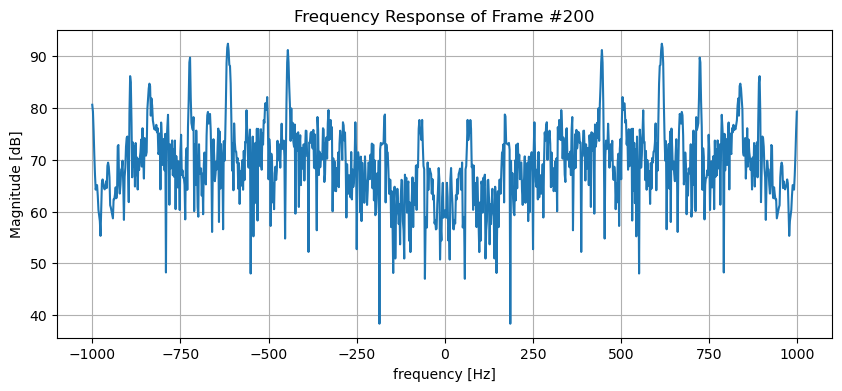

In [155]:
#frequency response - output of FFT
from numpy.fft import fftshift, fft, fftfreq

freq_responses = np.array([np.fft.fft(windowed_frame, 1024) for windowed_frame in windowed_frames])

#squared output of frequency response
mag_squared = np.abs(freq_responses)

#needed to shift to prevent weird wrapping around index
frame_index = 200
frame_fft = fft(windowed_frames[frame_index])
shifted_mag = np.abs(fftshift(frame_fft))
shifted_freq = fftshift(fftfreq(fifo_size, d=1/fs_decimated))

dB_mag_frame = 20 * np.log10(mag_squared[frame_index])

plt.figure(figsize=(10,4))
plt.title(f"Frequency Response of Frame #{frame_index}")
plt.ylabel("Magnitude [dB]")
plt.xlabel("frequency [Hz]")
plt.plot(shifted_freq, dB_mag_frame)
plt.grid()
if PLOT: plt.show()

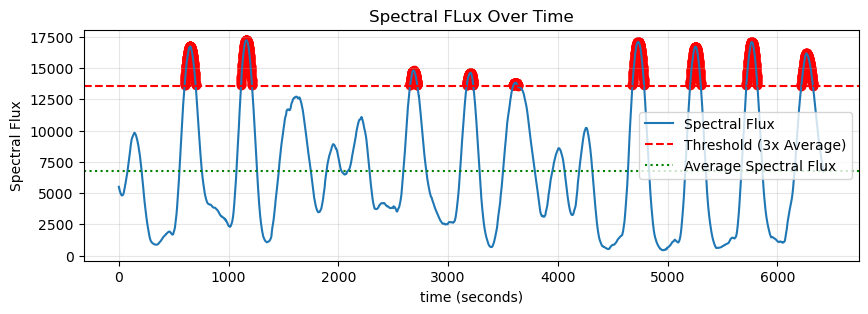

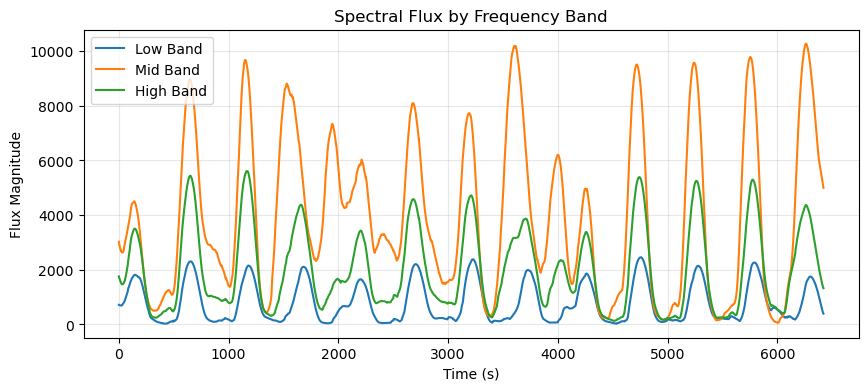

In [157]:
#Spectral Flux
#Calculate differences between frames
diff_fft = np.diff(mag_squared, axis=0) #take differences between frames
mask = diff_fft < 0
diff_fft[mask] = 0

#Sum across frequencies
window_duration = fifo_size / fs_decimated #in seconds
spectral_flux = np.sum(diff_fft, axis=1)
flux_time = np.arange(len(spectral_flux)) * window_duration

#rolling average threshold
average_spectral_flux = np.mean(spectral_flux)
threshold = 2 * average_spectral_flux #we used 3

#splitting into bins as per Verilog Code
low_bin_max = 200 #Hz
mid_bin_max = 1500
high_bin_max = fs_decimated / 2 #nyquist

freq_res = fs_decimated / fifo_size
low_bin_index = int(low_bin_max / freq_res)
mid_bin_index = int(mid_bin_max / freq_res)

#spectral flux per band
low_flux = np.sum(diff_fft[:, :low_bin_index], axis=1)
mid_flux = np.sum(diff_fft[:, low_bin_index:mid_bin_index], axis=1)
high_flux = np.sum(diff_fft[:, mid_bin_index:], axis=1)

#Plot total Spectral Flux Values over Threshold
plt.figure(figsize=(10,3))
plt.plot(flux_time, spectral_flux, label='Spectral Flux')
plt.axhline(threshold, color='r', linestyle='--', label=f"Threshold (3x Average)")
plt.axhline(average_spectral_flux, color='g', linestyle=':', label=f'Average Spectral Flux')
plt.xlabel("time (seconds)")
plt.ylabel("Spectral Flux")
plt.title("Spectral FLux Over Time")
plt.legend()
plt.grid(True, alpha=0.3)

beat_times = flux_time[spectral_flux > threshold]
plt.scatter(beat_times, spectral_flux[spectral_flux > threshold], color='red')

#plot each band
plt.figure(figsize=(10, 4))
plt.plot(flux_time, low_flux, label='Low Band')
plt.plot(flux_time, mid_flux, label='Mid Band')
plt.plot(flux_time, high_flux, label='High Band')
plt.title("Spectral Flux by Frequency Band")
plt.xlabel("Time (s)")
plt.ylabel("Flux Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


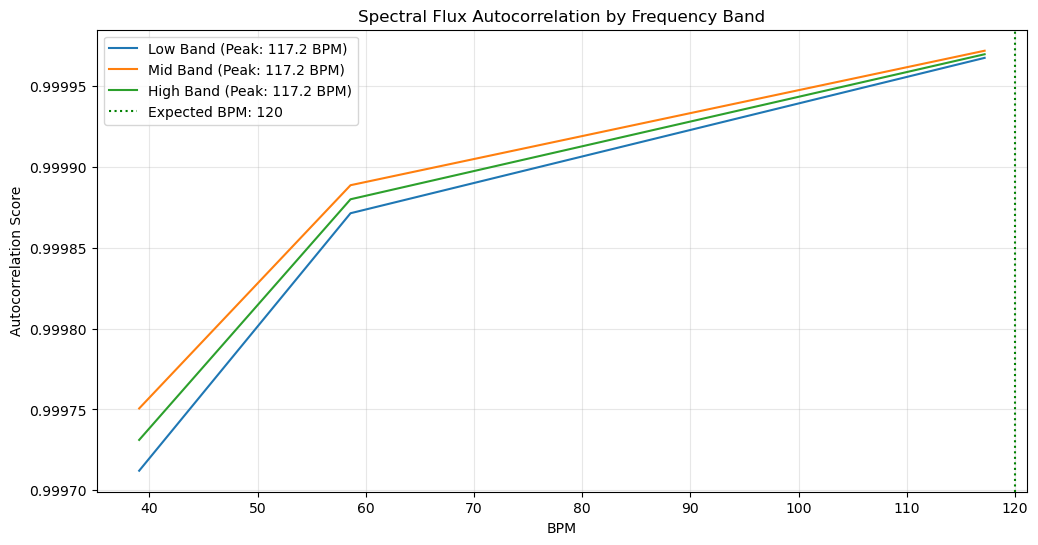

Estimated BPMs by Band:
Low: 117.19 BPM (Weight: 1.00)
Mid: 117.19 BPM (Weight: 1.00)
High: 117.19 BPM (Weight: 1.00)

Weighted BPM Estimate: 117.19


In [192]:
# --- Autocorrelation BPM Estimation ---

min_bpm = 40
max_bpm = 200

# Flux frame rate (how often we get one spectral flux sample)
frame_hop_sec = fifo_size / fs_decimated    # seconds per flux frame
flux_rate = 1.0 / frame_hop_sec             # flux frames per second

# Lag range in units of flux frames
lower_lag = max(1, int(np.floor(flux_rate * 60 / max_bpm)))
upper_lag = int(np.ceil(flux_rate * 60 / min_bpm))
lags = np.arange(lower_lag, upper_lag + 1)

bpm_axis = 60 * flux_rate / lags

# def autocorrelation_jagged(flux, lags):
#     scores = []
#     for lag in lags:
#         shifted = flux[:-lag]
#         original = flux[lag:]
#         min_len = min(len(shifted), len(original))
#         if min_len <= 1:
#             scores.append(0)
#             continue
#         # Normalize correlation by length for comparability
#         score = np.dot(shifted[:min_len], original[:min_len]) / min_len
#         scores.append(score)
#     return np.array(scores)

def autocorrelation_jagged(flux, lags):
    scores = []
    flux = (flux - np.mean(flux))  # zero-mean
    for lag in lags:
        shifted = flux[:-lag]
        original = flux[lag:]
        min_len = min(len(shifted), len(original))
        if min_len <= 1:
            scores.append(0)
            continue
        # Pearson correlation style
        score = np.corrcoef(shifted[:min_len], original[:min_len])[0,1]
        scores.append(score)
    return np.array(scores)

# Bands to analyze
bands = {
    "Low": low_flux,
    "Mid": mid_flux,
    "High": high_flux
}

band_scores = {}
band_bpms = {}
band_weights = {}

plt.figure(figsize=(12, 6))
for name, flux in bands.items():
    scores = autocorrelation_jagged(flux, lags)
    band_scores[name] = scores

    best_idx = np.argmax(scores)
    bpm = bpm_axis[best_idx]
    band_bpms[name] = bpm
    band_weights[name] = scores[best_idx]  

    plt.plot(bpm_axis, scores, label=f"{name} Band (Peak: {bpm:.1f} BPM)")

plt.axvline(expected_bpm, color='g', linestyle=':', label=f'Expected BPM: {expected_bpm}')
plt.xlabel("BPM")
plt.ylabel("Autocorrelation Score")
plt.title("Spectral Flux Autocorrelation by Frequency Band")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Weighted BPM across bands
total_weight = sum(band_weights.values())
weighted_bpm = sum(band_bpms[band] * band_weights[band] for band in bands) / total_weight

print("Estimated BPMs by Band:")
for band in bands:
    print(f"{band}: {band_bpms[band]:.2f} BPM (Weight: {band_weights[band]:.2f})")

print(f"\nWeighted BPM Estimate: {weighted_bpm:.2f}")
